In [222]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, RobustScaler
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

df = pd.read_csv("../data/merged_data.csv", parse_dates=["datetime"])
df = df.sort_values("datetime")
df["hour"] = df["datetime"].dt.hour
df["is_daytime"] = ((df["hour"] >= 7) & (df["hour"] < 19)).astype(int)

df = df.drop(columns=["hour"])

df["sin_hour"] = np.sin(2 * np.pi * df["datetime"].dt.hour / 24)
df["cos_hour"] = np.cos(2 * np.pi * df["datetime"].dt.hour / 24)
df["price_lag_1h"] = df["price_EUR_MWh"].shift(1)

df = df.dropna()

features = [
    "temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation", "quantity_solar",
    "quantity_other", "price_lag_1h", "is_daytime", "sin_hour", "cos_hour", "quantity_MW"
]
target = "price_EUR_MWh"

# Splitting indices before scaling
val_days = 30
val_size = val_days * 24

train_df = df.iloc[:-val_size]
val_df = df.iloc[-val_size:]

# Fit scalers ONLY on training data
scaler_x = StandardScaler()
scaler_y = StandardScaler()

scaler_x.fit(train_df[features])
scaler_y.fit(train_df[[target]])

# Transform entire dataset safely
X = scaler_x.transform(df[features])
y = scaler_y.transform(df[[target]])


In [223]:
print(df["price_EUR_MWh"].describe())


count    26022.000000
mean       121.387423
std        108.597326
min       -500.000000
25%         70.435000
50%         98.040000
75%        132.000000
max        872.960000
Name: price_EUR_MWh, dtype: float64


In [224]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset for time series data with fixed sequence length.
    """
    def __init__(self, X, y, seq_len):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx+self.seq_len],
            self.y[idx+self.seq_len]
        )

class DSSM(nn.Module):
    """
    Deep Structured State Model (DSSM) for time series forecasting.
    This model uses a GRU for state representation and a feedforward network for observation modeling.
    """
    def __init__(self, input_dim, state_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.GRU(input_dim, state_dim, batch_first=True, num_layers=2, dropout=0.15 )
        self.obs_model = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )


    def forward(self, x):
        state_seq, _ = self.rnn(x)
        output = self.obs_model(state_seq[:, -1, :])
        return output.squeeze(-1)

In [225]:
# Splitting the dataset into training and validation sets
# Assuming the data is hourly and we want to validate on the last 30 days
sequence_length = 24 # 24 hours = 1 day
val_days = 30
val_size = val_days * 24

train_X = X[:-val_size]
train_y = y[:-val_size]
val_X = X[-val_size - sequence_length:]
val_y = y[-val_size - sequence_length:]

train_dataset = TimeSeriesDataset(train_X, train_y, sequence_length)
val_dataset = TimeSeriesDataset(val_X, val_y, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, optimizer, and loss function
model = DSSM(input_dim=X.shape[1], state_dim=64, hidden_dim=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.L1Loss()

# Training the model
n_epochs = 30
model.train()
for epoch in range(n_epochs):
    epoch_loss = 0
    for x, t in train_loader:
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, t.squeeze(-1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, t in val_loader:
            preds = model(x)
            loss = criterion(preds, t.squeeze(-1))
            val_loss += loss.item()
    model.train()

    print(f"Epoch {epoch+1}, Train Loss: {epoch_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

Epoch 1, Train Loss: 0.3201, Val Loss: 0.1665
Epoch 2, Train Loss: 0.2165, Val Loss: 0.1652
Epoch 3, Train Loss: 0.1926, Val Loss: 0.1526
Epoch 4, Train Loss: 0.1812, Val Loss: 0.1459
Epoch 5, Train Loss: 0.1739, Val Loss: 0.1481
Epoch 6, Train Loss: 0.1727, Val Loss: 0.1477
Epoch 7, Train Loss: 0.1711, Val Loss: 0.1464
Epoch 8, Train Loss: 0.1760, Val Loss: 0.1464
Epoch 9, Train Loss: 0.1706, Val Loss: 0.1417
Epoch 10, Train Loss: 0.1719, Val Loss: 0.1454
Epoch 11, Train Loss: 0.1719, Val Loss: 0.1433
Epoch 12, Train Loss: 0.1705, Val Loss: 0.1368
Epoch 13, Train Loss: 0.1695, Val Loss: 0.1363
Epoch 14, Train Loss: 0.1670, Val Loss: 0.1371
Epoch 15, Train Loss: 0.1656, Val Loss: 0.1368
Epoch 16, Train Loss: 0.1639, Val Loss: 0.1341
Epoch 17, Train Loss: 0.1649, Val Loss: 0.1329
Epoch 18, Train Loss: 0.1612, Val Loss: 0.1379
Epoch 19, Train Loss: 0.1610, Val Loss: 0.1291
Epoch 20, Train Loss: 0.1583, Val Loss: 0.1367
Epoch 21, Train Loss: 0.1556, Val Loss: 0.1304
Epoch 22, Train Loss: 

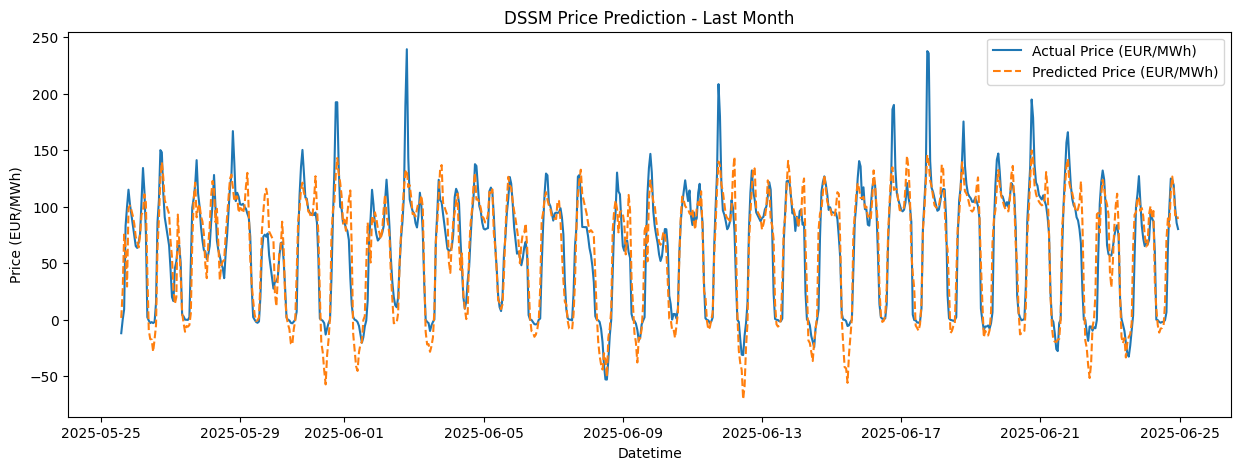

In [226]:
# Evaluation on the last month
model.eval()
all_preds = []
all_actuals = []
with torch.no_grad():
    for x, t in val_loader:
        preds = model(x)
        all_preds.append(preds.numpy())
        all_actuals.append(t.squeeze(-1).numpy())

preds_flat = np.concatenate(all_preds)
actuals_flat = np.concatenate(all_actuals)

preds_inverse = scaler_y.inverse_transform(preds_flat.reshape(-1, 1)).flatten()
actuals_inverse = scaler_y.inverse_transform(actuals_flat.reshape(-1, 1)).flatten()

# Plotting the results for the last month
val_datetimes = df["datetime"].iloc[-val_size:].reset_index(drop=True)

plt.figure(figsize=(15, 5))
plt.plot(val_datetimes, actuals_inverse, label="Actual Price (EUR/MWh)")
plt.plot(val_datetimes, preds_inverse, label="Predicted Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Prediction - Last Month")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

In [227]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actuals_inverse, preds_inverse)
mae = mean_absolute_error(actuals_inverse, preds_inverse)

denom = (np.abs(actuals_inverse) + np.abs(preds_inverse)) / 2
non_zero_mask = denom != 0
smape = np.mean(np.abs(actuals_inverse - preds_inverse)[non_zero_mask] / denom[non_zero_mask]) * 100

print(f"Validation Set Metrics:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


Validation Set Metrics:
MSE: 471.98
MAE: 15.61


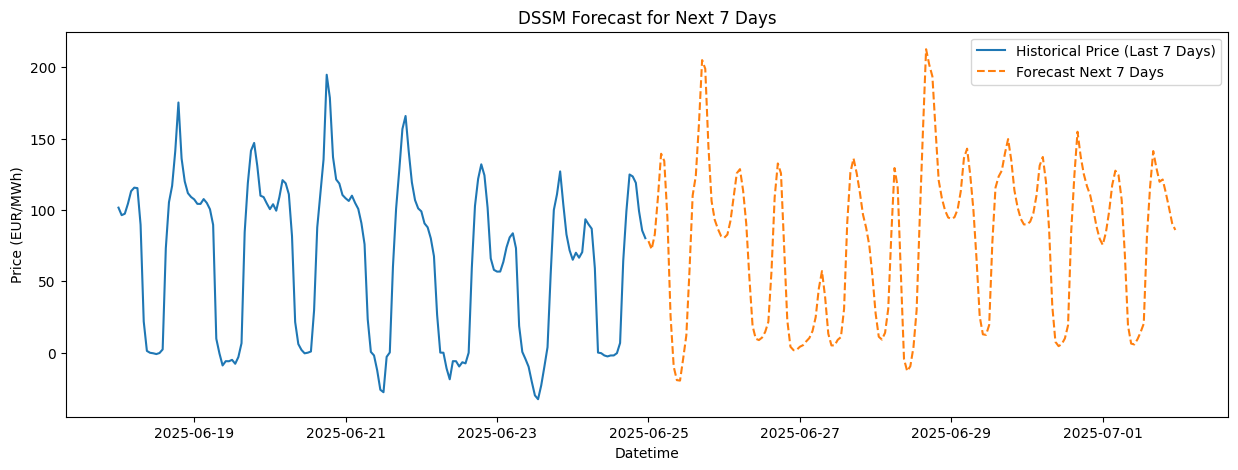

In [228]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

forecast_horizon = 168  # 7 days
sequence_length = 168

# Load weather forecast
weather_df = pd.read_csv("../data/weather_forecast.csv", parse_dates=["datetime"])
weather_df = weather_df.sort_values("datetime").reset_index(drop=True)

# Optional: Scale weather columns now if your model expects scaled weather inputs
weather_features = ["temperature_2m", "wind_speed_180m", "wind_speed_120m", "direct_radiation"]
scaler_weather = StandardScaler()
scaler_weather.fit(df[weather_features])  # Fit only on weather columns
# Scale weather forecast
weather_df[weather_features] = scaler_weather.transform(weather_df[weather_features])

# Prepare latest known features
latest_features = df[features].iloc[-sequence_length:].copy()
latest_scaled = scaler_x.transform(latest_features)

input_seq = torch.tensor(latest_scaled, dtype=torch.float32).unsqueeze(0)
current_seq = input_seq.clone()

forecast_scaled = []
forecast_unscaled = []

for i in range(forecast_horizon):
    model.eval()
    with torch.no_grad():
        pred_scaled = model(current_seq).item()  # Model predicts scaled price
        forecast_scaled.append(pred_scaled)

    pred_unscaled = scaler_y.inverse_transform(np.array([[pred_scaled]]))[0, 0]
    forecast_unscaled.append(pred_unscaled)

    shifted_seq = current_seq[:, 1:, :].squeeze(0).numpy()
    next_feature = shifted_seq[-1].copy()

    # Update lag price feature with scaled prediction (model output already scaled)
    idx_lag = features.index('price_lag_1h')
    next_feature[idx_lag] = pred_scaled

    # Generate new datetime
    new_datetime = df["datetime"].iloc[-1] + pd.Timedelta(hours=i + 1)

    # Update time features
    idx_day = features.index('is_daytime')
    next_feature[idx_day] = 1 if 6 <= new_datetime.hour < 20 else 0

    idx_sin = features.index('sin_hour')
    idx_cos = features.index('cos_hour')
    next_feature[idx_sin] = np.sin(2 * np.pi * new_datetime.hour / 24)
    next_feature[idx_cos] = np.cos(2 * np.pi * new_datetime.hour / 24)

    # Inject weather forecast if available
    weather_row = weather_df.loc[weather_df["datetime"] == new_datetime]
    if not weather_row.empty:
        for w_feat in weather_features:
            if w_feat in features:
                idx_w = features.index(w_feat)
                next_feature[idx_w] = weather_row.iloc[0][w_feat]
    else:
        print(f"No weather forecast for {new_datetime}, keeping last known values.")

    # Build new input sequence
    new_seq = np.vstack([shifted_seq, next_feature])
    current_seq = torch.tensor(new_seq, dtype=torch.float32).unsqueeze(0)

# Create forecast datetimes
forecast_datetimes = pd.date_range(
    start=df["datetime"].iloc[-1] + pd.Timedelta(hours=1),
    periods=forecast_horizon,
    freq="h"
)

# Plot historical + forecast
plt.figure(figsize=(15, 5))
plt.plot(df["datetime"].iloc[-7*24:], df["price_EUR_MWh"].iloc[-7*24:], label="Historical Price (Last 7 Days)")
plt.plot(forecast_datetimes, forecast_unscaled, label="Forecast Next 7 Days", linestyle="--")
plt.title("DSSM Forecast for Next 7 Days")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()


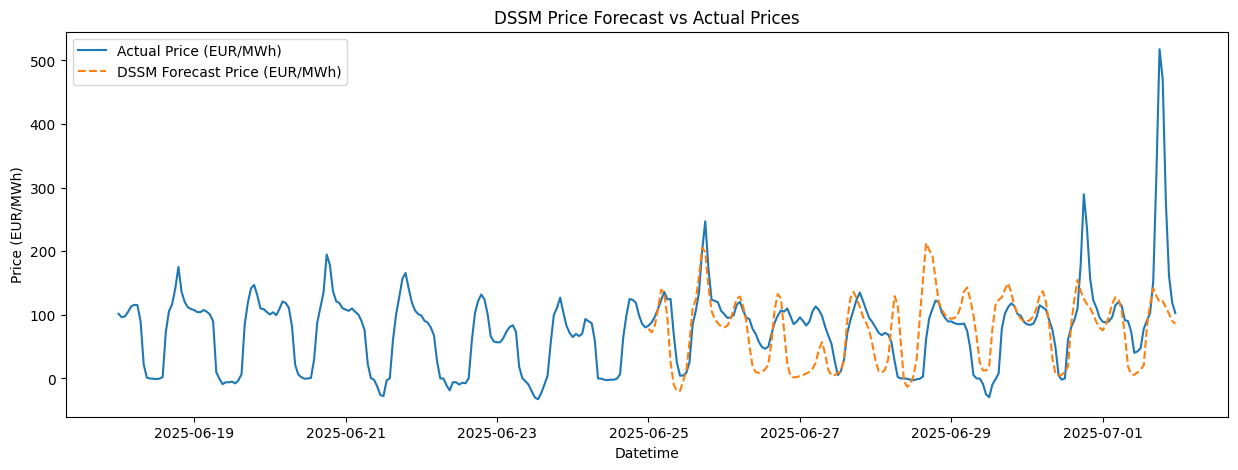

In [229]:
import sys
import pandas as pd
sys.path.append("../src")

from data.fetch_prices import get_energy_prices

df_prices = get_energy_prices("202506180000", "202507020000")

# plot vs predictions
plt.figure(figsize=(15, 5))
plt.plot(df_prices["datetime"], df_prices["price_EUR_MWh"], label="Actual Price (EUR/MWh)")
plt.plot(forecast_datetimes, forecast_unscaled, label="DSSM Forecast Price (EUR/MWh)", linestyle="--")
plt.title("DSSM Price Forecast vs Actual Prices")
plt.xlabel("Datetime")
plt.ylabel("Price (EUR/MWh)")
plt.legend()
plt.show()

